In [1]:
import tensorflow as tf
from keras.layers import Input, Lambda,subtract,GlobalMaxPooling2D,Dense,GlobalAveragePooling2D, concatenate, Activation
from keras.applications.mobilenet import MobileNet as Net

from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.models import Model
from keras.layers import Input, merge
from keras.optimizers import Adam
import cv2
import numpy as np
import os
#from tqdm import tqdm
from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import time
import glob

ALPHA = 0.7 # Triplet Loss Parameter

from keras.layers import Input,Lambda,subtract,GlobalMaxPooling2D,Dense,GlobalAveragePooling2D,concatenate,Activation
from keras.applications.xception import Xception as Net
from keras.preprocessing import image
from keras.applications.xception import preprocess_input
from keras.models import Model

import matplotlib.pyplot as plt

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix
import random as rn

np.random.seed(0)
tf.set_random_seed(3)

from sklearn.model_selection import cross_val_score

/Applications/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
# define the triplet loss to be used in cnn model

def triplet_loss(x):
    anchor, positive, negative = x
    
    #x = tf.constant([[1, 1, 1], [1, 1, 1]]) ------ tf.reduce_sum(x, 1)  # [3, 3]
    #It is trained in batches so, the tensor will be of the above shape for each triplet
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), 1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), 1)
    
    #x = tf.constant([[1, 1, 1], [1, 1, 1]])--------->tf.reduce_sum(x, 0)  # [2, 2, 2]

    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), ALPHA)
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), 0)

    return loss

In [3]:
def img_to_array(image):
    img = cv2.resize(image, (128, 128)) 
    x_train = np.array([img])
    return x_train

In [4]:
def img_path_to_array(image_path):
    img1 = cv2.imread(image_path, 1)
    return img_to_array(img1)

# Training Data

In [5]:
def prepare_database_tr(location):
    database = {}

    # load all the images of individuals to recognize into the database
    for file in glob.glob(location):
        identity = os.path.splitext(os.path.basename(file))[0].strip('NISDCC-_6g')
        #print (identity)
        database[identity] = img_path_to_array(file)

    return database

In [6]:
train_image_arrays = prepare_database_tr('/Users/ochhab3/Documents/ojaswinich_github/signature_verification/images/sigcomp2009/training/*.PNG')

## Triplet Formation

In [7]:
triplet_str_tr=[]

t1= time.time()
for i in range(1,13):
    for ja in range(1,6):
        for k in range(23,52):
             for jn in range(1,6):
                    for jp in range(1,6):
                        #print (i,ja,k,jn,jp)
                        if (jp!=ja):
                            
                            if(i<10):
                                a='00'+ str(i)+'_00'+str(i)+'_00'+str(ja)
                                b='00'+ str(i) +'_00'+str(i)+'_00'+str(jp)
                                c='0'+str(k)+'_00'+str(i)+'_00'+str(jn)
                            else:
                                a='0'+str(i)+'_0'+str(i)+'_00'+str(ja)
                                b='0'+str(i)+'_0'+str(i)+'_00'+str(jp)
                                c='0'+str(k)+'_0'+str(i)+'_00'+str(jn)
                            
                            x= (a,b,c)
                            triplet_str_tr.append(x)
                        
                    
t2=time.time()

print (t2-t1)


0.15772533416748047


In [8]:
anchor_tr=[]
positive_tr=[]
negative_tr=[]

for img_name in triplet_str_tr:
    anchor_tr.append(train_image_arrays[img_name[0]])
    positive_tr.append(train_image_arrays[img_name[1]])
    negative_tr.append(train_image_arrays[img_name[2]])

In [9]:
x_a_tr=np.array(anchor_tr).reshape((len(anchor_tr), 128,128,3))
x_p_tr=np.array(positive_tr).reshape((len(positive_tr), 128,128,3))
x_n_tr=np.array(negative_tr).reshape((len(negative_tr), 128,128,3))


In [10]:
len(anchor_tr)

34800

# Test Data

In [11]:
def prepare_test_dict(location):
    database = {}

    # load all the images of individuals to recognize into the database
    for file in glob.glob(location):
        identity = os.path.splitext(os.path.basename(file))[0].strip('NFI-')
        #print (identity)
        database[identity] = img_path_to_array(file)

    return database

In [12]:
test_genuine_dict = prepare_test_dict('/Users/ochhab3/Documents/ojaswinich_github/signature_verification/images/sigcomp2009/test/genuines/*')
test_forgery_dict = prepare_test_dict('/Users/ochhab3/Documents/ojaswinich_github/signature_verification/images/sigcomp2009/test/forgeries/*')

## Triplet Formation

In [13]:
all_ids = np.arange(1, 101)
missing_ids = np.array([5, 13, 25, 32, 34, 36, 38, 40, 48, 50, 52, 57, 60, 61, 65, 76, 78, 81, 82, 87, 95])
ids_available = np.array(list((set(all_ids)-set(missing_ids))))

In [14]:
j_formatted=[]
for i in range(1,13):
    if (i<10):
        new_j='0'+str(i)
    else:
        new_j=str(i)
    j_formatted.append(new_j)

In [15]:
i_formatted=[]
for i in ids_available:
    if (i<10):
        new_i='00'+str(i)
    elif(9<i<100):
        new_i='0'+str(i)
    else:
        new_i= str(i)
    i_formatted.append(new_i)

In [16]:
f_formatted=[]
for i in range(3,101):
    if (i<10):
        new_f='00'+str(i)
    elif(9<i<100):
        new_f='0'+str(i)
    else:
        new_f= str(i)
    f_formatted.append(new_f)

In [17]:
triplet_test_comb=[]
for i in i_formatted:
    for f in f_formatted:
        for ja in j_formatted:
            for jn in j_formatted[0:6]:
                for jp in j_formatted:
                    if (jp!=ja):
                        a=i+ja+i
                        p=i+jp+i
                        n=f+jn+i
                        triplet_test=(a,p,n)
                        triplet_test_comb.append(triplet_test)

In [18]:
final_triplet_test_id=[]
for i in range(0,len(triplet_test_comb)):
    if ((triplet_test_comb[i][0] in test_genuine_dict.keys()) and (triplet_test_comb[i][1] in test_genuine_dict.keys())and (triplet_test_comb[i][2] in test_forgery_dict.keys())):
        final_triplet_test_id.append(triplet_test_comb[i])

In [19]:
# subset test data triplets for training of cnn
import random
random.seed(0)
p_test=random.sample(range(1, len(final_triplet_test_id)), 45000)

In [20]:
new_test_id=[]
for i in p_test:
    new_test_id.append(final_triplet_test_id[i])


In [21]:
anchor_test=[]
positive_test=[]
negative_test=[]

for img_name in new_test_id:
    anchor_test.append(test_genuine_dict[img_name[0]])
    positive_test.append(test_genuine_dict[img_name[1]])
    negative_test.append(test_forgery_dict[img_name[2]])

In [22]:
x_a_test=np.array(anchor_test).reshape((len(anchor_test), 128,128,3))
x_p_test=np.array(positive_test).reshape((len(positive_test), 128,128,3))
x_n_test=np.array(negative_test).reshape((len(negative_test), 128,128,3))

In [23]:
len(anchor_test)

45000

# Dutch Data

In [24]:
def prepare_dut_dict(location):
    database = {}

    # load all the images of individuals to recognize into the database
    for file in glob.glob(location):
        identity = os.path.splitext(os.path.basename(file))[0].strip('K')
        #print (identity)
        database[identity] = img_path_to_array(file)

    return database

In [25]:
dut_all_dict = prepare_dut_dict('/Users/ochhab3/Documents/ojaswinich_github/signature_verification/images/dutch_updated/*')

In [26]:
dut_neg_dict={}

for i in dut_all_dict.keys():
    if len(i)==10 :
        dut_neg_dict[i]= dut_all_dict[i]


In [27]:
internal_count_ids = list(range(17, 70))
internal_count_ids.append(13)
internal_count_ids.sort()

In [28]:
internal_count_dict = {}
for i in range(0, len(internal_count_ids)):
    internal_count_dict['0'+str(internal_count_ids[i])]=1

dut_neg_dict_ord = {}

for i in dut_neg_dict.keys():
    person_id=i[-3:]
    image_id=internal_count_dict[person_id]
    #print(i, person_id, image_id)
    if image_id<10:
        dut_neg_dict_ord[person_id+'_0'+str(image_id)]= dut_neg_dict[i]
    else:
        dut_neg_dict_ord[person_id+'_'+str(image_id)]= dut_neg_dict[i]
    internal_count_dict[person_id]=internal_count_dict[person_id]+1
     

## Triplet Formation

In [29]:
dut_i_formatted = ['013']

for i in range(17, 70):
    dut_i_formatted.append('0'+str(i))

In [30]:
dut_j_formatted = []

for j in range(1,25):
    if (j<10):
        new_j='0'+str(j)
    else:
        new_j=str(j)
    dut_j_formatted.append(new_j)

In [31]:
triplet_dut_comb=[]
for i in dut_i_formatted:
        for ja in dut_j_formatted:
            for jn in dut_j_formatted[0:20]:
                for jp in dut_j_formatted:
                    if (jp!=ja):
                        a=ja+'_'+i
                        p=jp+'_'+i
                        n=i+'_'+jn
                        triplet_dut=(a,p,n)
                        triplet_dut_comb.append(triplet_dut)

In [32]:
final_triplet_dut_id=[]
for i in range(0,len(triplet_dut_comb)):
    if ((triplet_dut_comb[i][0] in dut_all_dict.keys()) and (triplet_dut_comb[i][1] in dut_all_dict.keys())and (triplet_dut_comb[i][2] in dut_neg_dict_ord.keys())):
        final_triplet_dut_id.append(triplet_dut_comb[i])

In [33]:
# subset dutch data triplets for training of cnn
import random
random.seed(0)
p_dut=random.sample(range(1, len(final_triplet_dut_id)), 40000)

In [34]:
new_dutch_id=[]
for i in p_dut:
    new_dutch_id.append(final_triplet_dut_id[i])


In [35]:
anchor_dut=[]
positive_dut=[]
negative_dut=[]

for img_name in new_dutch_id:
    anchor_dut.append(dut_all_dict[img_name[0]])
    positive_dut.append(dut_all_dict[img_name[1]])
    negative_dut.append(dut_neg_dict_ord[img_name[2]])

In [36]:
x_a_dut=np.array(anchor_dut).reshape((len(anchor_dut), 128,128,3))
x_p_dut=np.array(positive_dut).reshape((len(positive_dut), 128,128,3))
x_n_dut=np.array(negative_dut).reshape((len(negative_dut), 128,128,3))

In [37]:
len(anchor_dut)

40000

# Triplet Model

In [38]:
# running triplet model on train, test, and dutch

x_a_comb= np.vstack((x_a_tr,x_a_test,x_a_dut))
x_p_comb= np.vstack((x_p_tr,x_p_test,x_p_dut))
x_n_comb= np.vstack((x_n_tr,x_n_test,x_n_dut))

In [39]:
import keras
pretrained_model= keras.applications.mobilenet.MobileNet()

In [40]:
pretrained_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [41]:
layers_needed=pretrained_model.layers[0:82]

In [42]:
#Defining the Sequential model
baseline_model=Sequential()
for layer in layers_needed:
    baseline_model.add(layer)

In [43]:
layers_to_not_train= baseline_model.layers[0:79]

for layer in layers_to_not_train:
    layer.trainable=False
    

In [44]:
baseline_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [45]:
def create_model_new(d1, d2, c):
    
    # The triplet network takes 3 input images: 2 of the same class and 1 out-of-class sample
    #shape: A shape tuple (integers), not including the batch size. For instance, shape=(32,) 
    #indicates that the expected input will be batches of 32-dimensional vectors.
    
    anchor_example =   Input(shape=(d1, d2, c), name = 'anchor')
    positive_example = Input(shape=(d1, d2, c), name = 'positive')
    negative_example = Input(shape=(d1, d2, c), name = 'negative')
        
    base_model = baseline_model
    # the weights of this layer will be set to ones and fixed  (since they
    # are shared we could also leave them trainable to get a weighted sum)
    
    # feed all 3 inputs into the pretrained keras model
    x1 = base_model(anchor_example)
    x2 = base_model(positive_example)
    x3 = base_model(negative_example)
    
    # flatten/summarize the models output:
    # (here we could also use GlobalAveragePooling or simply Flatten everything)
    #Takes the max value for each of the filter
    anchor =   GlobalMaxPooling2D()(x1)
    positive = GlobalMaxPooling2D()(x2)
    negative = GlobalMaxPooling2D()(x3)
    
    
    #Loss gives the final loss value between a,p and n.
    loss = merge([anchor, positive, negative], mode=triplet_loss, output_shape=(1,))

    triplet_model = Model(inputs=[anchor_example, positive_example, negative_example],
                  outputs=loss)
    
    triplet_model.compile(loss='mean_absolute_error', optimizer=Adam())
    print(triplet_model.summary())
    
    return triplet_model

In [46]:
triplet_model=create_model_new(128, 128, 3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
positive (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
negative (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             3228864     anchor[0][0]                     
                                                                 positive[0][0]                   
          

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Applications/anaconda/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [47]:
# triplet_model.fit(x=[x_a_comb, x_p_comb, x_n_comb], y=np.zeros(x_a_comb.shape[0]), verbose=1, batch_size=2048, epochs=3)

In [49]:
# save the model trained above
triple_model_path = '/Users/ochhab3/Documents/ojaswinich_github/signature_verification/model_weights/triplet_weights_new_e3.h5'
# triplet_model.save_weights(triple_model_path)

# Load the weights of pre-trained final model

In [50]:
triplet_model.load_weights(triple_model_path)

## Embeddings

In [51]:
#Find the embeddings from the anchors
intermediate_layer_model_anchor = Model(inputs=triplet_model.input,
                                 outputs=triplet_model.get_layer('global_max_pooling2d_1').output)

In [52]:
#Find the embeddings from the positives
intermediate_layer_model_positive = Model(inputs=triplet_model.input,
                                 outputs=triplet_model.get_layer('global_max_pooling2d_2').output)

In [53]:
#Find the embeddings from the negatives
intermediate_layer_model_negative = Model(inputs=triplet_model.input,
                                 outputs=triplet_model.get_layer('global_max_pooling2d_3').output)

### Train Data Embeddings

In [54]:
anc_emb_tr=intermediate_layer_model_anchor.predict([x_a_tr, x_p_tr, x_n_tr])
pos_emb_tr=intermediate_layer_model_positive.predict([x_a_tr, x_p_tr, x_n_tr])
neg_emb_tr=intermediate_layer_model_negative.predict([x_a_tr, x_p_tr, x_n_tr])

### Test Data Embeddings

In [55]:
anc_emb_te=intermediate_layer_model_anchor.predict([x_a_test, x_p_test,x_n_test])
pos_emb_te=intermediate_layer_model_positive.predict([x_a_test, x_p_test,x_n_test])
neg_emb_te=intermediate_layer_model_negative.predict([x_a_test, x_p_test,x_n_test])

### Dutch Data Embeddings

In [56]:
anc_emb_dut=intermediate_layer_model_anchor.predict([x_a_dut, x_p_dut,x_n_dut])
pos_emb_dut=intermediate_layer_model_positive.predict([x_a_dut, x_p_dut,x_n_dut])
neg_emb_dut=intermediate_layer_model_negative.predict([x_a_dut, x_p_dut,x_n_dut])

### Train Data Embedding Dictionary

In [57]:
#Creating Unique Identification for training set

data_anc_tr = {}
data_pos_tr = {}
data_neg_tr = {}
for i in range(0,len(triplet_str_tr)):
    #Anchor dict
    a_id = triplet_str_tr[i][0]
    if a_id not in data_anc_tr.keys():
        data_anc_tr[a_id]= np.array(anc_emb_tr[i])
        
    #Pos dict
    p_id = triplet_str_tr[i][1]
    if p_id not in data_pos_tr.keys():
        data_pos_tr[p_id]= np.array(pos_emb_tr[i])
        
    #Neg dict
    n_id = triplet_str_tr[i][2]
    if n_id not in data_neg_tr.keys():
        data_neg_tr[n_id]= np.array(neg_emb_tr[i])


### Test Data Embedding Dictionary

In [58]:
#Creating Unique Identification for test set embedding

data_anc_te = {}
data_pos_te = {}
data_neg_te = {}
for i in range(0,len(new_test_id)):
    #Anchor dict
    a_id = new_test_id[i][0]
    if a_id not in data_anc_te.keys():
        data_anc_te[a_id]= np.array(anc_emb_te[i])
        
    #Pos dict
    p_id = new_test_id[i][1]
    if p_id not in data_pos_te.keys():
        data_pos_te[p_id]= np.array(pos_emb_te[i])
        
    #Neg dict
    n_id = new_test_id[i][2]
    if n_id not in data_neg_te.keys():
        data_neg_te[n_id]= np.array(neg_emb_te[i])

### Dutch Data Embedding Dictionary

In [59]:
#Creating Unique Identification for dutch data set embedding

data_anc_dut = {}
data_pos_dut = {}
data_neg_dut = {}
for i in range(0,len(new_dutch_id)):
    #Anchor dict
    a_id = new_dutch_id[i][0]
    if a_id not in data_anc_dut.keys():
        data_anc_dut[a_id]= np.array(anc_emb_dut[i])
        
    #Pos dict
    p_id = new_dutch_id[i][1]
    if p_id not in data_pos_dut.keys():
        data_pos_dut[p_id]= np.array(pos_emb_dut[i])
        
    #Neg dict
    n_id = new_dutch_id[i][2]
    if n_id not in data_neg_dut.keys():
        data_neg_dut[n_id]= np.array(neg_emb_dut[i])

### Train Data Pairs

In [60]:
#Pairwise pos str
pair_pos_str_tr=[]
for i in range(1,13):
    for ja in range(1,6):
        for jp in range(1,6):
            if (jp!=ja):
                if (i<10) :
                    a='00'+ str(i)+'_00'+str(i)+'_00'+str(ja)
                    b='00'+ str(i) +'_00'+str(i)+'_00'+str(jp)
                else :
                   a='0'+str(i)+'_0'+str(i)+'_00'+str(ja)
                   b='0'+str(i)+'_0'+str(i)+'_00'+str(jp)
                
                pos_pair=(a,b)
                pair_pos_str_tr.append(pos_pair)

In [61]:
#Pairwise negative str
pair_neg_str_tr=[]
for i in range(1,13):
    for ja in range(1,6):
        for k in range(23,52):
            for jn in range(1,6):
                if (i<10):
                    a='00'+ str(i)+'_00'+str(i)+'_00'+str(ja)
                    b='0'+ str(k) +'_00'+str(i)+'_00'+str(jn)
                else :
                    a='0'+ str(i)+'_0'+str(i)+'_00'+str(ja)
                    b='0'+ str(k)+'_0'+str(i)+'_00'+str(jn)
                    
                pair_neg=(a,b)
                pair_neg_str_tr.append(pair_neg)


In [62]:
sortd_pair_pos_str_tr=[]
for i in range(0,len(pair_pos_str_tr)):
    x=np.sort(pair_pos_str_tr[i])
    sortd_pair_pos_str_tr.append(x)
    
import pandas as pd
sortd_pair_pos_str_tr=pd.DataFrame(sortd_pair_pos_str_tr)

final_sortd_pair_pos_str_tr=sortd_pair_pos_str_tr.drop_duplicates()

list_pos_tr=[]
for i in range(0,len(final_sortd_pair_pos_str_tr)):
    x=[final_sortd_pair_pos_str_tr.iloc[i][0],final_sortd_pair_pos_str_tr.iloc[i][1]]
    list_pos_tr.append(x)
    

In [63]:
sortd_pair_neg_str_tr=[]
for i in range(0,len(pair_neg_str_tr)):
    x=np.sort(pair_neg_str_tr[i])
    sortd_pair_neg_str_tr.append(x)
    
sortd_pair_neg_str_tr=pd.DataFrame(sortd_pair_neg_str_tr)

final_sortd_pair_neg_str_tr=sortd_pair_neg_str_tr.drop_duplicates()

list_neg_tr=[]
for i in range(0,len(final_sortd_pair_neg_str_tr)):
    x=[final_sortd_pair_neg_str_tr.iloc[i][0],final_sortd_pair_neg_str_tr.iloc[i][1]]
    list_neg_tr.append(x)

### Test Data Pairs

In [64]:
#Pairwise pos str
pair_pos_str_te=[]
for i in i_formatted:
    for ja in j_formatted:
        for jp in j_formatted:
            if (jp!=ja):
                a=i+ja+i
                p=i+jp+i
                pos_pair=(a,p)
                pair_pos_str_te.append(pos_pair)

In [65]:
#Pairwise negative str
pair_neg_str_te=[]
for i in i_formatted:
    for f in f_formatted:
        for ja in j_formatted:
            for jn in j_formatted[0:6]:
                a=i+ja+i
                n=f+jn+i
                pair_neg=(a,n)
                pair_neg_str_te.append(pair_neg)

In [66]:
sortd_pair_pos_str_te=[]
for i in range(0,len(pair_pos_str_te)):
    x=np.sort(pair_pos_str_te[i])
    sortd_pair_pos_str_te.append(x)

sortd_pair_pos_str_te=pd.DataFrame(sortd_pair_pos_str_te)

final_sortd_pair_pos_str_te=sortd_pair_pos_str_te.drop_duplicates()

list_pos_te=[]
for i in range(0,len(final_sortd_pair_pos_str_te)):
    x=[final_sortd_pair_pos_str_te.iloc[i][0],final_sortd_pair_pos_str_te.iloc[i][1]]
    list_pos_te.append(x)
    

In [67]:
sortd_pair_neg_str_te=[]
for i in range(0,len(pair_neg_str_te)):
    x=np.sort(pair_neg_str_te[i])
    sortd_pair_neg_str_te.append(x)
    
sortd_pair_neg_str_te=pd.DataFrame(sortd_pair_neg_str_te)

final_sortd_pair_neg_str_te=sortd_pair_neg_str_te.drop_duplicates()

list_neg_te=[]
for i in range(0,len(final_sortd_pair_neg_str_te)):
    x=[final_sortd_pair_neg_str_te.iloc[i][0],final_sortd_pair_neg_str_te.iloc[i][1]]
    list_neg_te.append(x)

In [68]:
# only getting the combinations that are present in the embedding dictionary

list_pos_te_fn=[]
for i in list_pos_te:
    if (i[0] in data_anc_te.keys() and i[1] in data_pos_te.keys()):
        list_pos_te_fn.append(i)

list_neg_te_fn=[]
for i in list_neg_te:
    if (i[0] in data_anc_te.keys() and i[1] in data_neg_te.keys()):
        list_neg_te_fn.append(i)


### Dutch Data Pairs

In [69]:
pair_pos_str_dut=[]

for i in dut_i_formatted:
    for ja in dut_j_formatted:
        for jp in dut_j_formatted:
            if (jp!=ja):
                a=ja+'_'+i
                p=jp+'_'+i
                pair_dut=(a,p)
                pair_pos_str_dut.append(pair_dut)


In [70]:
pair_neg_str_dut=[]

for i in dut_i_formatted:
    for ja in dut_j_formatted:
        for jn in dut_j_formatted[0:20]:
                a=ja+'_'+i
                n=i+'_'+jn
                pair_dut=(a,n)
                pair_neg_str_dut.append(pair_dut)


In [71]:
sortd_pair_pos_str_dut=[]
for i in range(0,len(pair_pos_str_dut)):
    x=np.sort(pair_pos_str_dut[i])
    sortd_pair_pos_str_dut.append(x)
    
sortd_pair_pos_str_dut=pd.DataFrame(sortd_pair_pos_str_dut)  
final_sortd_pair_pos_str_dut=sortd_pair_pos_str_dut.drop_duplicates()

list_pos_dt=[]
for i in range(0,len(final_sortd_pair_pos_str_dut)):
    x=[final_sortd_pair_pos_str_dut.iloc[i][0],final_sortd_pair_pos_str_dut.iloc[i][1]]
    list_pos_dt.append(x)

In [72]:
sortd_pair_neg_str_dut=[]
for i in range(0,len(pair_neg_str_dut)):
    x=np.sort(pair_neg_str_dut[i])
    sortd_pair_neg_str_dut.append(x)
    
sortd_pair_neg_str_dut=pd.DataFrame(sortd_pair_neg_str_dut)
final_sortd_pair_neg_str_dut=sortd_pair_neg_str_dut.drop_duplicates()

list_neg_dt=[]
for i in range(0,len(final_sortd_pair_neg_str_dut)):
    x=[final_sortd_pair_neg_str_dut.iloc[i][0],final_sortd_pair_neg_str_dut.iloc[i][1]]
    list_neg_dt.append(x)

In [73]:
# only getting the combinations that are present in the embedding dictionary
list_pos_dt_fn=[]
for i in list_pos_dt:
    if (i[0] in data_anc_dut.keys() and i[1] in data_pos_dut.keys()):
        list_pos_dt_fn.append(i)

list_neg_dt_fn=[]
for i in list_neg_dt:
    if (i[0] in data_anc_dut.keys() and i[1] in data_neg_dut.keys()):
        list_neg_dt_fn.append(i)

### Train Features

In [74]:
#Positive Features
pos_feat_tr=np.zeros((len(list_pos_tr),1024))
for i in range(0,len(list_pos_tr)):
    x1=data_anc_tr[list_pos_tr[i][0]]
    x2=data_anc_tr[list_pos_tr[i][1]]
    pos_feat_tr[i]=x1-x2


In [75]:
#Negative Features
neg_feat_tr=np.zeros((len(list_neg_tr),1024))
for i in range(0,len(list_neg_tr)):
    x1=data_anc_tr[list_neg_tr[i][0]]
    x2=data_neg_tr[list_neg_tr[i][1]]
    neg_feat_tr[i]=x1-x2

In [76]:
print(pos_feat_tr.shape, neg_feat_tr.shape)

(120, 1024) (8700, 1024)


### Test Features

In [77]:
#Positive Features
pos_feat_te=np.zeros((len(list_pos_te_fn),1024))
for i in range(0,len(list_pos_te_fn)):
    x1=data_anc_te[list_pos_te_fn[i][0]]
    x2=data_pos_te[list_pos_te_fn[i][1]]
    pos_feat_te[i]=x1-x2


In [78]:
#Negative Features
neg_feat_te=np.zeros((len(list_neg_te_fn),1024))
for i in range(0,len(list_neg_te_fn)):
    x1=data_anc_te[list_neg_te_fn[i][0]]
    x2=data_neg_te[list_neg_te_fn[i][1]]
    neg_feat_te[i]=x1-x2


In [79]:
print(pos_feat_te.shape, neg_feat_te.shape)

(1203, 1024) (2016, 1024)


### Dutch Features

In [80]:
#Positive Features
pos_feat_dut=np.zeros((len(list_pos_dt_fn),1024))
for i in range(0,len(list_pos_dt_fn)):
    x1=data_anc_dut[list_pos_dt_fn[i][0]]
    x2=data_pos_dut[list_pos_dt_fn[i][1]]
    pos_feat_dut[i]=x1-x2


In [81]:
#Negative Features
neg_feat_dut=np.zeros((len(list_neg_dt_fn),1024))
for i in range(0,len(list_neg_dt_fn)):
    x1=data_anc_dut[list_neg_dt_fn[i][0]]
    x2=data_neg_dut[list_neg_dt_fn[i][1]]
    neg_feat_dut[i]=x1-x2


In [82]:
print(pos_feat_dut.shape, neg_feat_dut.shape)

(14858, 1024) (1755, 1024)


In [83]:
# total positive pairs
14858+1203+120

16181

In [84]:
# total negative pairs
8700+2016+1755

12471

### COMBINE TEST TRAIN FEAT

In [85]:
pos_feat_total=np.vstack((pos_feat_tr,pos_feat_te,pos_feat_dut))

In [86]:
neg_feat_total=np.vstack((neg_feat_tr,neg_feat_te, neg_feat_dut))

In [87]:
feat_total=np.vstack((pos_feat_total,neg_feat_total))

### Genuine as 0 and Forged as 1

In [88]:
pos_Y = [0]*len(pos_feat_total)
#makes that no of ones as the len of the item given
neg_Y = [1]*len(neg_feat_total)
#rowwise appends the two arrays
train_y=np.append(pos_Y, neg_Y)

In [89]:
#training on 80% data and test on remaining 20% data
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(feat_total, train_y, test_size=0.2, random_state=42)

/Applications/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [90]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(random_state=0)
log_model.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [375]:
# train accuracy
log_model.score(x_train,y_train)

0.9849483006849614

In [376]:
# test accuracy
log_model.score(x_test,y_test)

0.9654510556621881

In [377]:
# precision recall on test data
print (recall_score(y_test, log_model.predict(x_test)))
print (precision_score(y_test, log_model.predict(x_test)))

0.967558799675588
0.9528753993610224


In [380]:
y_pred=log_model.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[3147,  118],
       [  80, 2386]])

In [381]:
cross_val_score(log_model, x_train, y_train, cv=10)

array([0.96685565, 0.95377235, 0.95551679, 0.95769734, 0.96249455,
       0.96247818, 0.95853339, 0.96377128, 0.95635094, 0.95591445])

In [382]:
cross_val_score(log_model, x_train, y_train, cv=10,scoring='precision')

array([0.95837463, 0.94350842, 0.94373149, 0.94752475, 0.95073892,
       0.957     , 0.94669299, 0.95083579, 0.94204322, 0.93429952])

In [383]:
cross_val_score(log_model, x_train, y_train, cv=10,scoring='recall')

array([0.96603397, 0.95104895, 0.95504496, 0.95604396, 0.96403596,
       0.957     , 0.959     , 0.967     , 0.959     , 0.967     ])

In [384]:
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(n_estimators=500, max_depth=10,random_state=0)
 
forest_model.fit(x_train,y_train)

/Applications/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [385]:
# train accuracy
forest_model.score(x_train,y_train)

0.9667117490510885

In [386]:
# test accuracy
forest_model.score(x_test,y_test)

0.946257197696737

In [387]:
# precision recall on test data
print (recall_score(y_test, forest_model.predict(x_test)))
print (precision_score(y_test, forest_model.predict(x_test)))

0.8864557988645579
0.987353206865402


In [388]:
y_pred=forest_model.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[3237,   28],
       [ 280, 2186]])

In [ ]:
# save the log model weights
import pickle
log_model_path = '/Users/ochhab3/Documents/ojaswinich_github/signature_verification/model_weights/log_model_e3.pkl'
file_object=open(log_model_path, 'wb')
s=pickle.dump(log_model, file_object)
file_object.close()

In [204]:
#Distance between Positive and Anchor ---> d_ap
d_ap=[]
for i in range(0,len(x_a_test)):
    d_ap.append(np.linalg.norm(anc_emb_te[i]-pos_emb_te[i]))

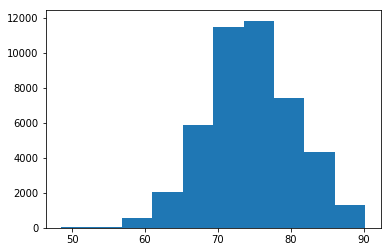

In [205]:
plt.hist(d_ap)
plt.show()

In [206]:
#Distance between Negative and Anchor ---> d_an
d_an=[]
for i in range(0,len(x_a_test)):
    d_an.append(np.linalg.norm(anc_emb_te[i]-neg_emb_te[i]))

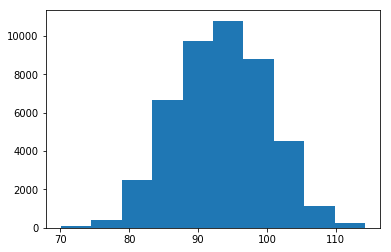

In [207]:
plt.hist(d_an)
plt.show()

In [198]:
#Distance of distances ---> d_final
d_final = []
for i in range(0,len(d_ap)):
    diff = d_ap[i]-d_an[i]
    d_final.append(diff)
    

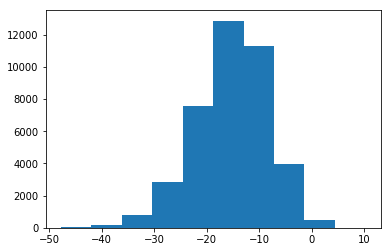

In [199]:
plt.hist(d_final)
plt.show()